---

## Khmer News Classification with fastText
---

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from datetime import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [23]:
data = pd.read_excel('/content/drive/news_classification_data_km.xlsx', encoding="UTF-8")
data.head(3)

,id,content,tokenized_content,category,category_en,text_prep
0,45541,រាជធានីភ្នំពេញ ៖នៅក្នុងពិភពសិល្បៈតារាសម្តែងមួយ...,រាជ ធានី ភ្នំ ពេញ ៖ នៅ ក្នុង ពិភព សិល្បៈ តារា ...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ នៅ ក្នុង ពិភព សិល្បៈ តារា សម...
1,52071,រាជធានីភ្នំពេញ ៖ ក្រុមតន្ត្រីថ្មីមួយដែលមានឈ្មោ...,រាជ ធានី ភ្នំ ពេញ ៖ ក្រុម តន្ត្រី ថ្មី មួយ ដែល...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ ក្រុម តន្ត្រី ថ្មី មួយ ដែល ម...
2,8906,រូបកាយយើងនេះញាំញីទៅដោយជំងឺដង្កាត់គ្រប់ប្រភេទ អ...,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...


### Preprocessing

In [ ]:
data['text_prep'] = data['tokenized_content'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))
data.drop_duplicates(subset=['text_prep'], inplace=True)

In [24]:
data.shape

(7418, 6)

In [25]:
data['texts_tokenized'] = data.text_prep.apply(lambda x: x.split())

In [26]:
data['category_en'].value_counts()

research              999
health                999
national-news         999
international-news    999
arts-and-culture      998
service               994
sports-news           769
business              661
Name: category_en, dtype: int64

In [27]:
## Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data.loc[:, 'category_en'].copy().tolist())

In [28]:
data[['category_en', 'label']].drop_duplicates(subset=['category_en']).sort_values(by=['label']).reset_index(drop=True)

,category_en,label
0,arts-and-culture,0
1,business,1
2,health,2
3,international-news,3
4,national-news,4
5,research,5
6,service,6
7,sports-news,7


In [29]:
data.head(3)

,id,content,tokenized_content,category,category_en,text_prep,texts_tokenized,label
0,45541,រាជធានីភ្នំពេញ ៖នៅក្នុងពិភពសិល្បៈតារាសម្តែងមួយ...,រាជ ធានី ភ្នំ ពេញ ៖ នៅ ក្នុង ពិភព សិល្បៈ តារា ...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ នៅ ក្នុង ពិភព សិល្បៈ តារា សម...,"[រាជ, ធានី, ភ្នំ, ពេញ, នៅ, ក្នុង, ពិភព, សិល្បៈ...",0
1,52071,រាជធានីភ្នំពេញ ៖ ក្រុមតន្ត្រីថ្មីមួយដែលមានឈ្មោ...,រាជ ធានី ភ្នំ ពេញ ៖ ក្រុម តន្ត្រី ថ្មី មួយ ដែល...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ ក្រុម តន្ត្រី ថ្មី មួយ ដែល ម...,"[រាជ, ធានី, ភ្នំ, ពេញ, ក្រុម, តន្ត្រី, ថ្មី, ម...",0
2,8906,រូបកាយយើងនេះញាំញីទៅដោយជំងឺដង្កាត់គ្រប់ប្រភេទ អ...,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,"[រូប, កាយ, យើង, នេះ, ញាំញី, ទៅ, ដោយ, ជំងឺ, ដង្...",0


### Data Partitioning

In [53]:
X = data['texts_tokenized']
y = data['label']

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1234, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=1234, shuffle=True, stratify=y_val)

print("""Training shape: {}
Validation shape: {}
Testing shape: {}""".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Training shape: 5192
Validation shape: 1558
Testing shape: 668


### Load fastText pre-trained model

In [32]:
from gensim.models import KeyedVectors

path = "/content/drive/cc.km.300.vec"
fastText_model = KeyedVectors.load_word2vec_format(path, binary=False)

In [33]:
len(fastText_model.vocab)

242732

In [34]:
fastText_model.vector_size

300

### Feature Extraction

In [35]:
def embedding_vectorizer(fastText_model, docs):
    mean_vecs = []
    for instance in docs:
        vecs = []
        for word in instance:
            if word in fastText_model.vocab:
                vecs.append(fastText_model[word])
            else:
                vecs.append(np.zeros(fastText_model.vector_size))
                
        mean_vecs.append(np.mean(vecs, axis=0))
        
    return mean_vecs

In [55]:
%%time
x_train_vectorized = pd.DataFrame(embedding_vectorizer(fastText_model, X_train)).add_prefix('col_')
x_val_vectorized = pd.DataFrame(embedding_vectorizer(fastText_model, X_val)).add_prefix('col_')
x_test_vectorized = pd.DataFrame(embedding_vectorizer(fastText_model, X_test)).add_prefix('col_')

CPU times: user 8.34 s, sys: 141 ms, total: 8.49 s
Wall time: 8.49 s


### Model Architecture

In [37]:
import tensorflow as tf
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [56]:
from keras.utils import to_categorical

y_train_k = to_categorical(y_train, num_classes=8)
y_val_k = to_categorical(y_val, num_classes=8)
y_test_k = to_categorical(y_test, num_classes=8)

In [58]:
np.random.seed(2)
rn.seed(3)
history = History()

model = Sequential()
model.add(Dense(1024, input_dim=300, activation="tanh"))
# model.add(Dropout(0.1))
model.add(Dense(512, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(256, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(8, activation="softmax"))

model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(np.array(x_train_vectorized), np.array(y_train_k), 
          validation_data=(np.array(x_val_vectorized), np.array(y_val_k)), 
          epochs=30, 
          batch_size=3000, 
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Train on 5192 samples, validate on 1558 samples
Epoch 1/30
5192/5192 [==============================] - 0s 63us/step - loss: 2.0659 - accuracy: 0.1851 - val_loss: 2.0033 - val_accuracy: 0.3370
Epoch 2/30
5192/5192 [==============================] - 0s 7us/step - loss: 1.9847 - accuracy: 0.3760 - val_loss: 1.8969 - val_accuracy: 0.4949
Epoch 3/30
5192/5192 [==============================] - 0s 7us/step - loss: 1.8666 - accuracy: 0.5258 - val_loss: 1.7350 - val_accuracy: 0.5642
Epoch 4/30
5192/5192 [==============================] - 0s 7us/step - loss: 1.6928 - accuracy: 0.5697 - val_loss: 1.5149 - val_accuracy: 0.5809
Epoch 5/30
5192/5192 [==============================] - 0s 7us/step - loss: 1.4692 - accuracy: 0.5859 - val_loss: 1.3082 - val_accuracy: 0.5963
Epoch 6/30
5192/5192 [==============================] - 0s 7us/step - loss: 1.2689 - accuracy: 0.6115 - val_loss: 1.1551 - val_accuracy: 0.6476
Epoch 7/30
5192/5192 [==============================] - 0s 7us/step - loss: 1.1289 - ac

In [81]:
## for learning curve
his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

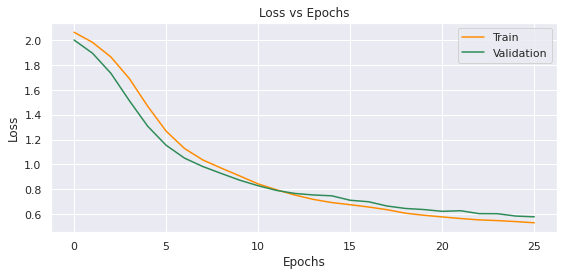

In [85]:
## Plot learning curve
import matplotlib.pyplot as plt
sns.set()
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(his_train_loss,'darkorange')
plt.plot(his_val_loss, 'seagreen')

plt.title("Loss vs Epochs", fontdict={'fontsize': 12})
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig("news_loss_vs_epochs_fastText.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [87]:
loss, test_accuracy = model.evaluate(np.array(x_test_vectorized), np.array(y_test_k), verbose=0)

In [89]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

accuracy_table = pd.DataFrame([round(train_accuracy, 3), round(val_accuracy, 3), round(test_accuracy, 3)], 
             index=['Training', 'Validation', 'Test'], 
             columns=['Accuracy'])
accuracy_table

,Accuracy
Training,0.826
Validation,0.815
Test,0.832


### Prediction

In [90]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [92]:
y_pred = model.predict(np.array(x_test_vectorized))
ac = accuracy_score(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
print("Test Accuracy:", round(ac, 2))

Test Accuracy: 0.83


In [ ]:
## generate confusion matrix
cm = confusion_matrix(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))

In [94]:
print("Confusion Matrix: ")
p = pd.DataFrame(cm, 
                 index=[['Actual']*8,list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))], 
                 columns=[['Predicted']*8,list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))])

p.style.set_properties(**{'background-color': 'skyblue', 
                          'color': 'black'})

Confusion Matrix: 


In [96]:
p = pd.DataFrame(cm, 
                 index=list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])), 
                 columns=list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])))

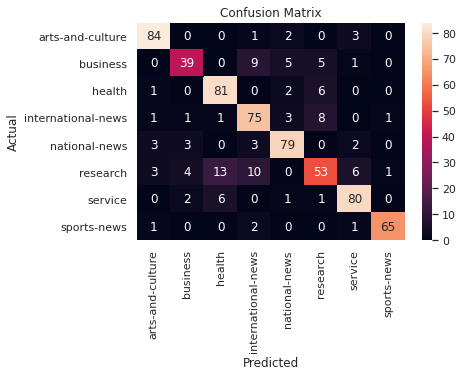

In [98]:
## Confusion Matrix in Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(12, 8))
sns.set()
f = sns.heatmap(p, annot=True)
plt.title("Confusion Matrix", fontdict={'fontsize': 12})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

f.get_figure().savefig("news_confusion_matrix_fastText.jpg", dpi=300, bbox_inches='tight')

In [99]:
## Classification Report
target_names = list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))
print(classification_report(y_test_k.argmax(axis=1), y_pred.argmax(axis=1), target_names = target_names))

                    precision    recall  f1-score   support

  arts-and-culture       0.90      0.93      0.92        90
          business       0.80      0.66      0.72        59
            health       0.80      0.90      0.85        90
international-news       0.75      0.83      0.79        90
     national-news       0.86      0.88      0.87        90
          research       0.73      0.59      0.65        90
           service       0.86      0.89      0.87        90
       sports-news       0.97      0.94      0.96        69

          accuracy                           0.83       668
         macro avg       0.83      0.83      0.83       668
      weighted avg       0.83      0.83      0.83       668

